In [173]:
#Importing librariers
import pandas as pd
import numpy as np

In [174]:
#reading in school data + performing cleaning to include necessary rows
lookup = pd.read_csv("~/shared_data_read_only/NCES_School_Lookup.csv")
lookup.columns = lookup.iloc[5]
lookup.columns = ['Name', 'State','Agency','County','ZIP','City','Student','FreeLunch','Reduced','FL+R','Teachers','P/T ratio']
                  
lookup = lookup.iloc[6:]
lookup = lookup.reset_index(drop=True)
lookup = lookup[:3569]
lookup = lookup.drop([1674,2583,3491])

In [175]:
#handling corner cases for Student, FL+R number of student fields by converting types
lookup['Student'] = lookup['Student'].astype(float)
lookup['FL+R'] = lookup['FL+R'].astype(str)
lookup['FL+R'] = lookup['FL+R'].str.replace('–','0')
lookup['FL+R'] = lookup['FL+R'].str.replace('‡','0')
lookup['FL+R'] = lookup['FL+R'].astype(float)

lookup['Teachers'] = lookup['Teachers'].astype(float)

In [176]:
#computing per student & per/teacher metrics to contextualize school size & resources
look = lookup.groupby('County').agg({'Student':'sum','FL+R':'sum','Teachers':'sum'}).reset_index()
look['Student/Teacher'] = look['Student']/look['Teachers']
look['FL+R/Student'] = look['FL+R']/look['Student']

In [177]:
look

,County,Student,FL+R,Teachers,Student/Teacher,FL+R/Student
0,Adams County,4573.0,2079.0,266.12,17.183977,0.454625
1,Allen County,14843.0,3575.0,920.19,16.130364,0.240854
2,Ashland County,7101.0,2387.0,431.41,16.459980,0.336150
3,Ashtabula County,12975.0,4903.0,703.09,18.454252,0.377881
4,Athens County,7054.0,1717.0,524.46,13.450025,0.243408
...,...,...,...,...,...,...
83,Washington County,7652.0,3516.0,473.06,16.175538,0.459488
84,Wayne County,15147.0,5712.0,934.08,16.215956,0.377104
85,Williams County,5386.0,1748.0,349.90,15.392969,0.324545
86,Wood County,18785.0,4985.0,1142.37,16.443884,0.265371


In [178]:
#reading in performance data for different districts
district = pd.read_excel("~/shared_data_read_only/District_and_School_Performance_Index_Ranking.xlsx",
                         'Building PI Rankings')

In [179]:
#data cleaning
district['2023 PI for Ranking'] = district['2023 PI for Ranking'].astype(str)
district['2023 PI for Ranking'] = district['2023 PI for Ranking'].str.replace('NC','0')
district['2023 PI for Ranking'] = district['2023 PI for Ranking'].astype(float)

In [180]:
#string transformation + renaming columns accordingly
lookup['Name'] = lookup['Name'].str.lower()
district['Building Name'] = district['Building Name'].str.lower()
district.rename(columns={'Building Name': 'Name'},inplace=True)

In [181]:
#computing a weighted average for school performance based on number of students
school = pd.merge(lookup, district, on='Name')
school['pi_student'] = school['2023 PI for Ranking'] * school['Student']
school_city = school.groupby('City').agg({'Student':'sum','FL+R':'sum','Teachers':'sum','pi_student':'sum'}).reset_index()
school_city['pi_city'] = school_city['pi_student']/school_city['Student']

In [182]:
#sorting school_city academic information and computig per student capita data
school_city = school_city.sort_values(by='pi_city',ascending=False)
school_city['FLR ratio'] = school_city['FL+R']/ school_city['Student']
school_city['Teachers ratio'] = school_city['Teachers']/ school_city['Student']

In [183]:
#filtering schools for final 
final_school = school_city[['City','Student','FLR ratio','Teachers ratio','pi_city']]
final_school = final_school.reset_index(drop=True)

In [184]:
final_school

,City,Student,FLR ratio,Teachers ratio,pi_city
0,Hinckley,369.0,0.097561,0.051843,112.140000
1,Terrace Park,296.0,0.067568,0.059966,111.373000
2,Gates Mills,128.0,0.210938,0.046875,111.250000
3,Solon,4917.0,0.114501,0.054423,110.618227
4,Maria Stein,864.0,0.026620,0.060752,110.593000
...,...,...,...,...,...
660,North College Hill,634.0,0.796530,0.046041,57.540000
661,Trotwood,2891.0,0.000000,0.056261,55.426618
662,Newburgh Heights,207.0,0.000000,0.028986,55.041000
663,Lockland,552.0,0.000000,0.048913,51.717408


In [185]:
#reading in and querying appropriate crime data
crime = pd.read_excel("~/Team-9/ohio_crime.xls")
crime["total crime"] = crime["Violent\ncrime"]+crime["Property\ncrime"]
crime["Crime Rate"] = crime["total crime"]/crime["Population"]*100
crime = crime[["City", "Population", "Crime Rate"]]

In [186]:
#reading in and querying appropriate income data
city_income = pd.read_excel("~/Team-9/city_income.xlsx")
city_income = city_income[["City", "2021 median household income"]]

In [187]:
city_income["2021 median household income"] = city_income['2021 median household income'].str.replace('$', '').str.replace(',', '').astype(int)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


In [188]:
#merging all independent datasets into centralized data grouped by city
city_school_crime = pd.merge(final_school, crime, on='City')
city_complete = pd.merge(city_school_crime, city_income, on='City')
city_complete = city_complete[city_complete['2021 median household income'] >= 40000]
city_complete = city_complete.set_index('City')
city_complete = city_complete[['FLR ratio','Teachers ratio','pi_city','Population','Crime Rate',
             '2021 median household income']]

<AxesSubplot:>

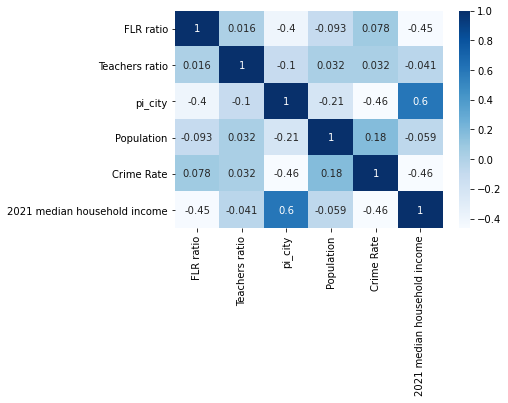

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(city_complete.corr(),annot=True,cmap='Blues')

In [190]:
city_complete

,FLR ratio,Teachers ratio,pi_city,Population,Crime Rate,2021 median household income
City,,,,,,
Solon,0.114501,0.054423,110.618227,22830,0.998686,118418
Waterville,0.099602,0.046813,105.801000,5518,0.561798,79857
Bay Village,0.071740,0.062384,105.126651,15235,0.498851,111516
Hudson,0.046258,0.062841,104.646960,22286,0.551916,143143
New Albany,0.054356,0.055779,104.097910,11332,1.023650,206130
...,...,...,...,...,...,...
Richmond Heights,0.702736,0.067289,64.227037,10346,1.933114,51290
Lorain,0.000000,0.059136,63.231184,64022,2.695948,42201
Euclid,0.192022,0.060185,62.827600,46659,3.274824,42056


In [191]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#running KMeans with optimal number of clusters
city_complete.columns = ['FLR ratio','Teachers ratio','pi_city','Population','Crime Rate',
             'm_hhld_income']

In [194]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(city_complete)
city_complete['clusters'] = clusters

In [195]:
city_complete.groupby('clusters')[city_complete.columns].agg({'mean'})

,FLR ratio,Teachers ratio,pi_city,Population,Crime Rate,m_hhld_income,clusters
,mean,mean,mean,mean,mean,mean,mean
clusters,,,,,,,
0,0.352416,0.054644,79.713520,57344.250000,2.740371,57413.300000,0
1,0.134641,0.054306,98.909364,22431.000000,1.233609,119511.423077,1
2,0.334528,0.054743,85.344924,14544.069307,2.095392,60467.574257,2


In [196]:
#looking at all possible cities with best household income range
merge_final = city_complete[city_complete['clusters'] == 2]
merge_fin1 = merge_final[merge_final['m_hhld_income'] > 66396]
merge_fin1 = merge_fin1[merge_fin1['m_hhld_income'] < 82996]

In [197]:
merge_fin1

,FLR ratio,Teachers ratio,pi_city,Population,Crime Rate,m_hhld_income,clusters
City,,,,,,,
Waterville,0.099602,0.046813,105.801000,5518,0.561798,79857,2
North Royalton,0.150659,0.052363,101.348632,30177,0.450674,74775,2
Loveland,0.144032,0.049076,100.398038,13245,0.671952,75610,2
Chardon,0.137143,0.049286,100.265769,5183,1.987266,79737,2
Centerville,0.117647,0.055187,97.390037,23744,1.263477,76565,2
Milford,0.178052,0.049147,97.093461,6880,2.122093,67188,2
Amherst,0.228756,0.052296,93.605724,12166,1.241164,78716,2
Fairview Park,0.282269,0.059567,93.542029,16201,0.919696,70451,2
Brunswick,0.194807,0.053236,93.117215,34977,0.588958,74353,2


In [198]:
#using PCA for dimensionality reduction to visualize interaction of 6 features across different cluster groups
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
ind = city_complete.iloc[:,:-1]
clus = city_complete['clusters'].tolist()
ind2 = StandardScaler().fit_transform(ind)

pca = PCA(n_components=2)
comp = pca.fit_transform(ind2)

prince = pd.DataFrame(data = comp, columns = ['pca1', 'pca2'])
prince['cluster'] = clus

In [199]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PCA1', 'PCA2'],index=ind.columns)

In [200]:
prince['cluster'] = prince['cluster'].map({0:'Risk heavy', 1:'Top earners', 2:'All-around'})

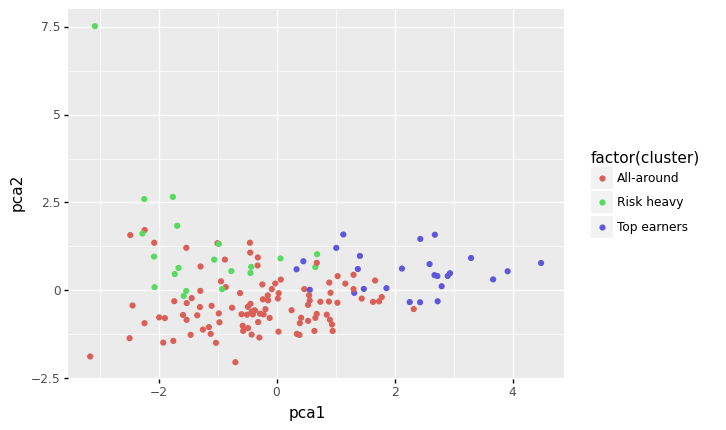

<ggplot: (-9223363262564826238)>

In [201]:
import plotnine
from plotnine import *
ggplot(prince) + geom_point(aes(x='pca1',y='pca2',color='factor(cluster)'))

In [202]:
#This matrix tells us how each feature weights the different parameters
#we can read this table to look at coefficient between the pca and the variable of interest
#For example, we want to priortize higher pca1 since they have positive, strong correlation with population, school rankings
loading_matrix

,PCA1,PCA2
FLR ratio,-0.584351,-0.597377
Teachers ratio,-0.123020,0.165471
pi_city,0.856885,-0.055666
Population,-0.228173,0.796413
Crime Rate,-0.675422,0.344481
m_hhld_income,0.851332,0.156658
